In [215]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [732]:
class FairRegressionTransform():
    def __init__(self, base_method, split=True, sigma=1e-6):
        self.base_method = base_method
        self.split = split
        self.sigma = sigma
    def fit(self, X_unlab, weights):
        self.weights = weights
        self.sensitives = np.unique(X_unlab[:, -1])
        K = len(self.sensitives)
        assert K != 1, 'Only one sensitive attribute provided'
        assert len(self.weights) == K, 'There are {} sensitive features, but {} weights'.format(K, len(self.weights))
        N, _ = X_unlab.shape
        permutation = np.random.permutation(N)
        if self.split:
            tmp = int(N / 2)
            X1 = X_unlab[permutation[:tmp]]
            X2 = X_unlab[permutation[tmp:]]
        else:
            X1 = X_unlab
            X2 = X_unlab
        pred1 = self.base_method.predict(X1) + np.random.uniform(-self.sigma, self.sigma, tmp)
        pred2 = self.base_method.predict(X2) + np.random.uniform(-self.sigma, self.sigma, N - tmp)
        self.quantile = {}
        self.cdf = {}
        for s in self.sensitives:
            self.quantile[s] = pred1[X1[:,-1] == s]
            self.cdf[s] = pred2[X2[:,-1] == s]
    def predict(self, X):
        n_test, _ = X.shape
        unfair = self.base_method.predict(X) + np.random.uniform(-self.sigma, self.sigma, n_test)
        y_pred = np.zeros(n_test)
        for ind, pred in enumerate(unfair):
            q = np.sum(self.cdf[X[ind,-1]] <= pred) / len(self.cdf[X[ind,-1]])
            for s in self.sensitives:
                y_pred[ind] += self.weights[s] * np.quantile(self.quantile[s], q, interpolation='lower')
        return y_pred

In [810]:
N_train = 500
thr = 0

X_train = np.random.normal(0, 1, (N_train, 3))
sens = np.zeros(N_train)
sens[X_train[:, 0] < thr] = -1
sens[X_train[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_train = np.append(X_train, sens, axis=1)
y_train = np.dot(X_train, np.ones(4) * 3) + np.random.normal(0, 1, N_train)


N_unlab = 1000
X_unlab = np.random.normal(0, 1, (N_unlab, 3))
sens = np.zeros(N_unlab)
sens[X_unlab[:, 0] < thr] = -1
sens[X_unlab[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_unlab = np.append(X_unlab, sens, axis=1)


N_test = 1000
X_test = np.random.normal(0, 1, (N_test, 3))
sens = np.zeros(N_test)
sens[X_test[:, 0] < thr] = -1
sens[X_test[:, 0] >= thr] = 1
sens = sens[:, np.newaxis]
X_test = np.append(X_test, sens, axis=1)


weights = {-1 : 0.5, 1 : 0.5}

In [811]:
ls = LinearRegression(fit_intercept=False)
ls.fit(X_train, y_train)
fair_ls = FairRegressionTransform(ls, sigma=1e-8)
fair_ls.fit(X_unlab, weights)

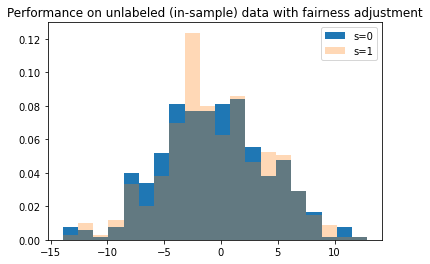

In [812]:
y_pred = fair_ls.predict(X_unlab)
y_pred0 = y_pred[X_unlab[:, -1] == -1]
y_pred1 = y_pred[X_unlab[:, -1] == 1]

plt.figure('1')
plt.hist(y_pred0, label='s=0', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Performance on unlabeled (in-sample) data with fairness adjustment')
plt.legend()



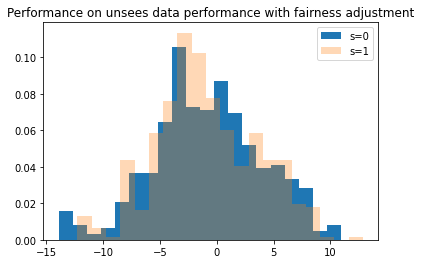

In [813]:
y_pred = fair_ls.predict(X_test)
y_pred0 = y_pred[X_test[:, -1] == -1]
y_pred1 = y_pred[X_test[:, -1] == 1]

plt.figure('2')
plt.hist(y_pred0, label='s=0', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Performance on unsees data performance with fairness adjustment')
plt.legend()

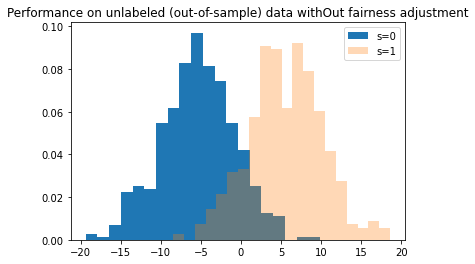

In [814]:
y_pred = ls.predict(X_unlab)
y_pred0 = y_pred[X_unlab[:, -1] == -1]
y_pred1 = y_pred[X_unlab[:, -1] == 1]

plt.figure('3')
plt.hist(y_pred0, label='s=0', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Performance on unlabeled (out-of-sample) data withOut fairness adjustment')
plt.legend()


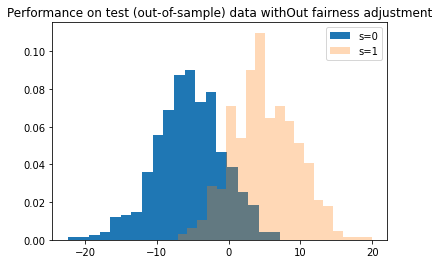

In [815]:
y_pred = ls.predict(X_test)
y_pred0 = y_pred[X_test[:, -1] == -1]
y_pred1 = y_pred[X_test[:, -1] == 1]

plt.figure('4')
plt.hist(y_pred0, label='s=0', density=True, stacked=True, bins=20)
plt.hist(y_pred1, label='s=1', alpha=0.3, density=True, stacked=True, bins=20)
plt.title('Performance on test (out-of-sample) data withOut fairness adjustment')
plt.legend()